# Środowiska ciągłe
### Katarzyna Stępień, Alicja Wójcik, Kacper Stankiewicz

In [5]:
# for autoformatting
# %load_ext jupyter_black

In [6]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglu1-mesa
  libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev
  libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev
  libsm-dev libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 45 not upgraded.
Need t

## Imports

In [31]:
import gymnasium as gym
import numpy as np

In [32]:
from stable_baselines3 import PPO

In [57]:
from stable_baselines3.ppo.policies import MlpPolicy
from gymnasium import Env
from stable_baselines3.common.base_class import BaseAlgorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Uczenie modelu

W projekcie wykorzystaliśmy ciągłą wersję środowiska MountainCar.

MDP Mountain Car to deterministyczne środowisko Markowa (MDP) 2D, w którym umieszczony jest samochód na dole sinusoidalnej doliny. Jedyne dostępne akcje to przyspieszenia, które można zastosować do samochodu w dwóch dostępnych kierunkach (przód-tył samochodu). Celem MDP jest strategiczne przyspieszenie samochodu, tak, aby osiągnąć stan docelowy na szczycie prawego wzgórza. W bibliotece Gymnasium istnieją dwie wersje tego środowiska: jedna z dyskretnymi akcjami i druga z ciągłymi. Wersja użyta w tym projekcie korzysta z ciągłych akcji.

In [37]:
env = gym.make("MountainCarContinuous-v0")

Do usprawnienia manipulacji hiperparametrów stworzyliśmy klasę pomocniczą, z domyślnymi wartościami parametrów ustawionymi według rekomendacji [repozytorium RL Zoo](https://github.com/DLR-RM/rl-baselines3-zoo)

In [36]:
from typing import Dict
from dataclasses import dataclass, asdict, field

@dataclass
class Params:
  normalize_advantage: bool = True
  policy: str = "MlpPolicy"
  batch_size: int = 256
  n_steps: int = 32
  gamma: float = 0.9999
  learning_rate: float = float(7.77e-05)
  ent_coef: float = 0.00429
  clip_range: float = 0.1
  n_epochs: int = 100
  gae_lambda: float = 0.9
  max_grad_norm: int = 5
  vf_coef: float = 0.19
  use_sde: bool = True
  policy_kwargs: Dict = field(default_factory=lambda: dict(log_std_init=-3.29, ortho_init=False))

W bibliotece stable_baselines dostępna jest już wyspecjalizowana funkcja do ewaluacji efektów uczenia modelu. Na potrzeby zadania wykorzystaliśmy ją do zbierania statystyk.

In [38]:
from stable_baselines3.common.evaluation import evaluate_policy

In [45]:
import matplotlib.pyplot as plt
import time

def evaluate_and_plot(model: BaseAlgorithm, env: Env, n_eval_episodes: int, warn: bool, deterministic:bool, repeat: int):
  rewards = []
  std_rewards = []
  total_time = 0
  for i in range(repeat):
    start_time = time.time()
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes, deterministic)
    end_time = time.time() - start_time
    rewards.append(mean_reward)
    std_rewards.append(std_reward)
    print(f"Iteration: {i+1}, Evaluation time: {end_time}")
    total_time += end_time
  print(f"Total evaluation time: {total_time}")

  plt.figure(figsize=(10, 5))  # Set the figure size
  y, x = zip(*[(reward, index) for index, reward in enumerate(rewards)])

  plt.plot(list(x), list(y), "-b", label="mean reward")
  plt.plot(list(x), std_rewards, "-r", label="std deviation")
  plt.legend(loc="upper left")

  plt.xlabel('Episode')
  plt.ylabel('Reward')

  plt.title('Rewards per Episode - Mountain cart continuous PPO')
  plt.savefig('rewards_plot_ppo.png')
  plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Wizualizacja uczenia - nagranie wideo


In [40]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [41]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Do "nagrania" wideo wykorzystany został wrapper VecVideoRecorder.

In [42]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Uczenie modelu wraz z wizualizacją statystyk oraz nagranie zachowania agenta




In [47]:
def create_model_and_evaluate(params, env, learning_steps, repeat):
  merged_dict = asdict(params) | {"env": env}
  model = PPO(**merged_dict)
  start_time = time.time()
  model.learn(total_timesteps=learning_steps)
  end_time = time.time() - start_time
  print(f"Total learning time: {end_time}")
  evaluate_and_plot(model, env, n_eval_episodes=100, warn=False, deterministic=False, repeat=repeat)
  record_video("MountainCarContinuous-v0", model, video_length=2000, prefix="ppo-mountain-car")

### Parametry domyślne

/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Iteration: 1, Evaluation time: 71.79352951049805
Iteration: 2, Evaluation time: 70.72017335891724
Iteration: 3, Evaluation time: 71.25473999977112
Iteration: 4, Evaluation time: 83.59823727607727
Iteration: 5, Evaluation time: 73.97743034362793
Iteration: 6, Evaluation time: 71.75262475013733
Iteration: 7, Evaluation time: 70.69793128967285
Iteration: 8, Evaluation time: 70.86002159118652
Iteration: 9, Evaluation time: 71.8551971912384
Iteration: 10, Evaluation time: 70.87779593467712
Total evaluation time: 727.3876812458038


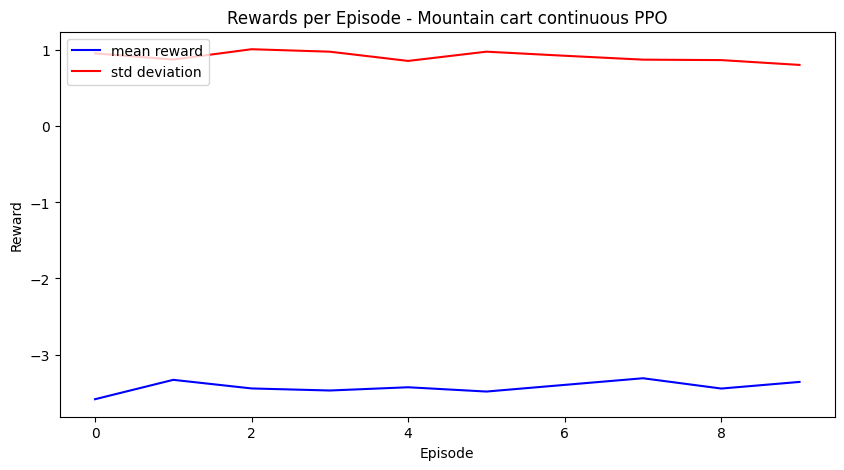

Saving video to /content/videos/ppo-mountain-car-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-step-0-to-step-2000.mp4


In [46]:
params = Params()
create_model_and_evaluate(params, env, 50_000, 10)

### Różne wariacje hiperparapmetrów

In [ ]:
params = Params()
create_model_and_evaluate(params, env, 50_000, 10)

In [ ]:
params = Params()
create_model_and_evaluate(params, env, 50_000, 10)

In [48]:
show_videos("videos", prefix="ppo")

## Eksperymenty z różnymi architekturami sieci

### Domyślnie wykorzystywana sieć - MlpPolicy

## Obserwacja zachowania agenta z wyłączonym trybem eksploracji